## Подготовим данные из kaggle с помощью API.

In [1]:
! pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 39kB/s 
     |████████████████████████████████| 3.9MB 31.2MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 450kB 32.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=7b84dca272afc31116176bac2a4aebb615ce8631d6ee3dd9c32911d6ae89113c
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tens

In [2]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!pip install tensorflow_addons
!pip install umap-learn
!pip install scann

Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 1.6MB 2.9MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 1.7 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72857 sha256=9bfdb7de40e8f28bf3d32b68bebae18853f2a01d9201affc57cffd6a07bd5213
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle
     |████████████████████████████████| 679 kB 2.9 MB/s 
     |████████████████████████████████| 80 kB 2.2 MB/s 
     |████████████████████████████████| 1.1 MB 4.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76566 sha256=bf0a09d7a7bcf6183dc8cb502b273d67662ae17682147024a588bd6fb1b35413
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a

In [10]:
!pwd
!mkdir ~/.kaggle
!echo '{"username":"polololya","key":"1f4ad1fc8a1535e236393da48a325aa8"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!cat ~/.kaggle/kaggle.json

/content
mkdir: cannot create directory ‘/root/.kaggle’: File exists
{"username":"polololya","key":"1f4ad1fc8a1535e236393da48a325aa8"}


In [11]:
!kaggle competitions download -c shopee-product-matching
!mkdir shopee-product-matching
!unzip -qq shopee-product-matching.zip -d shopee-product-matching

100% 1.68G/1.68G [00:53<00:00, 27.5MB/s]
100% 1.68G/1.68G [00:53<00:00, 33.7MB/s]
mkdir: cannot create directory ‘shopee-product-matching’: File exists


In [12]:
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b3.tar.gz
!wget https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/python/keras/applications/efficientnet_weight_update_util.py
!tar -xf noisy_student_efficientnet-b3.tar.gz
!python efficientnet_weight_update_util.py --model b3 --notop --ckpt noisy-student-efficientnet-b3/model.ckpt --o efficientnetb3_notop.h5

--2021-06-04 12:32:55--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b3.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.188.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90666978 (86M) [application/gzip]
Saving to: ‘noisy_student_efficientnet-b3.tar.gz.1’

noisy_student_effic 100%[===================>]  86.47M  48.2MB/s    in 1.8s    

2021-06-04 12:32:57 (48.2 MB/s) - ‘noisy_student_efficientnet-b3.tar.gz.1’ saved [90666978/90666978]

--2021-06-04 12:32:58--  https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/python/keras/applications/efficientnet_weight_update_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (ra

## Подготовим данные и построим модель

In [13]:
import io, os
import numpy as np
import pandas as pd

import tensorflow.keras as keras
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [14]:
all_train_df = pd.read_csv('/content/shopee-product-matching/train.csv')
test_df = pd.read_csv('/content/shopee-product-matching/test.csv')

all_train_df['image'] = '/content/shopee-product-matching/train_images/' + all_train_df['image']
test_df['image'] = '/content/shopee-product-matching/test_images/' + test_df['image']

all_train_df.sort_values(by='label_group', inplace=True)
all_train_df.head()

,posting_id,image,image_phash,title,label_group
3874,train_1646767365,/content/shopee-product-matching/train_images/...,e925873ed09cd08f,Sarung celana wadimor original 100% dewasa dan...,258047
31859,train_1528423085,/content/shopee-product-matching/train_images/...,ea97861c926a71e3,WARNA RANDOM ACAK Sarung Celana Wadimor MURAH ...,258047
6738,train_398181303,/content/shopee-product-matching/train_images/...,e9b5833e929e909c,SARUNG CELANA WADIMOR DEWASA HITAM POLOS SARCEL,258047
7613,train_2865605743,/content/shopee-product-matching/train_images/...,bfc3cc1cc636c14c,Wall Sticker / WallSticker - Submarine Measur...,297977
12367,train_1382500866,/content/shopee-product-matching/train_images/...,838436c07dff19e4,RELIZA WALL STICKER PENGUKUR TINGGI BADAN JERA...,297977


In [15]:
from sklearn.model_selection import GroupShuffleSplit
splitter = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(all_train_df, groups=all_train_df.label_group))
train_df = all_train_df.iloc[train_idx]
val_df = all_train_df.iloc[val_idx]

train_df.head()

,posting_id,image,image_phash,title,label_group
7613,train_2865605743,/content/shopee-product-matching/train_images/...,bfc3cc1cc636c14c,Wall Sticker / WallSticker - Submarine Measur...,297977
12367,train_1382500866,/content/shopee-product-matching/train_images/...,838436c07dff19e4,RELIZA WALL STICKER PENGUKUR TINGGI BADAN JERA...,297977
15610,train_2070644662,/content/shopee-product-matching/train_images/...,8a71617a016e1efd,LVN COLLAGEN - ORIGINAL TERMURAH - LVN STROBER...,645628
32085,train_2149563017,/content/shopee-product-matching/train_images/...,d5d4231fd2688d17,LVN COLLAGEN LVN STROBERI ORIGINAL 100% 1BOX I...,645628
27972,train_2419208039,/content/shopee-product-matching/train_images/...,c89817483f3f398e,LVN COLLAGEN / STROBERI,645628


In [11]:
train_df.shape, val_df.shape

((27188, 5), (7062, 5))

In [16]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
image_size = (300, 300)
BATCH_SIZE = 30

datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                             horizontal_flip=True,
                             zoom_range=[0.7, 1.0],
                             #height_shift_range = 0.1,
                             #width_shift_range = 0.1
                             )

params = dict(x_col="image",
              y_col="label_group",
              class_mode='raw',
              target_size=image_size,
              batch_size=BATCH_SIZE,
              shuffle=False)

train_generator = datagen.flow_from_dataframe(dataframe=train_df, **params)
val_generator = datagen.flow_from_dataframe(dataframe=val_df, **params)

Found 27188 validated image filenames.
Found 7062 validated image filenames.


In [17]:
from keras.layers import Dense, Lambda, BatchNormalization, Activation
from keras.models import Model
from keras.layers import PReLU
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

EMBEDDING_SIZE = 256

backbone_model = EfficientNetB3(weights="efficientnetb3_notop.h5", include_top=False, pooling='avg')
# TODO: Linear(512) + BN + PReLU

backbone_model.trainable = False
for layer in backbone_model.layers[-32:]: # 20
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True

# for layer in backbone_model.layers:
#   if isinstance(layer, keras.layers.BatchNormalization):
#     layer.trainable = False
x = backbone_model.output
model_embedding_raw = Dense(EMBEDDING_SIZE, activation='linear')(x)
model_embedding_normalized = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(model_embedding_raw)

embedding_model = Model(backbone_model.inputs, model_embedding_normalized)

embedding_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), # 0.001
    loss=tfa.losses.TripletSemiHardLoss())

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
class GroupShufflerV2():
  def __init__(self, df, group_col):
    self.groups = [df for _, df in df.groupby(group_col)]

  def sample(self, max_samples_per_group=5):
    np.random.shuffle(self.groups)

    groups = self.groups
    if max_samples_per_group is not None:
      groups = [x.sample(min(len(x), max_samples_per_group)) for x in groups]

    return pd.concat(groups)

In [ ]:
# np.ceil(num_samples / batch_size)

In [15]:
# val_loss: 0.3758

EPOCHS = 20
group_shuffler = GroupShufflerV2(train_df, 'label_group')

for _ in range(EPOCHS):
  train_generator = datagen.flow_from_dataframe(dataframe=group_shuffler.sample(max_samples_per_group=3), **params)
  history = embedding_model.fit(train_generator,
                                  validation_data=val_generator, 
                                  epochs=1,)
                              #  steps_per_epoch = np.ceil(train_df.shape[0]/BATCH_SIZE),
                              # validation_steps=np.ceil(val_df.shape[0]/BATCH_SIZE))

Found 20815 validated image filenames.
Epoch 1/20


FailedPreconditionError: ignored

In [16]:
# 0.278

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

params = dict(x_col="image",
              y_col="label_group",
              class_mode='raw',
              target_size=(450, 450),
              batch_size=30,
              shuffle=False)

#train_generator = datagen.flow_from_dataframe(dataframe=train_df, **params)
val_generator = datagen.flow_from_dataframe(dataframe=val_df, **params)

embedding_model.evaluate(val_generator)

Found 7062 validated image filenames.


ValueError: ignored

### Тест

inference is better at (400, 400)

In [ ]:
from keras.preprocessing.image import load_img
from tqdm.auto import tqdm

def predict_for_dataset(model, images):
  predictions = list()
  for batch in tqdm(np.array_split(images, len(images)//BATCH_SIZE)):
    batch_data = np.vstack([np.array(preprocess_input(load_img(img_path).resize(image_size)))[np.newaxis] for img_path in batch])
    predictions.append(model.predict(batch_data))
  return np.vstack(predictions)

val_embeddings = predict_for_dataset(embedding_model, val_df.image)

In [ ]:
from umap import UMAP
dim_reductor = UMAP(metric='cosine')
dim_reductor.fit(val_embeddings)

UMAP(a=None, angular_rp_forest=True, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='cosine', metric_kwds=None,
     min_dist=0.1, n_components=2, n_epochs=None, n_jobs=-1, n_neighbors=15,
     negative_sample_rate=5, output_dens=False, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, ...)

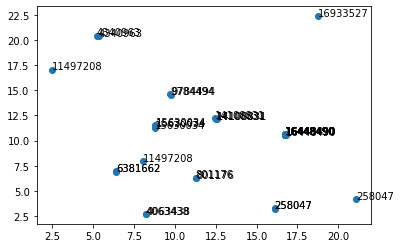

In [ ]:
import matplotlib.pylab as plt


X_images_embeddings_2d = dim_reductor.transform(val_embeddings[:30])
y_label = val_df.iloc[:30].label_group

plt.scatter(X_images_embeddings_2d[:,0], X_images_embeddings_2d[:,1], label=y_label)

for (x,y), text in zip(X_images_embeddings_2d, y_label): 
  plt.text(x, y, text)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
embedding_model.save('/content/drive/MyDrive/shared/NoisyEfficientNetB3__avg__256__zoom_flip__max3samples.h5')